In [16]:
import matplotlib.pyplot as plt

import numpy as np
from numpy.linalg import eig

import random

from scipy.sparse.csgraph import laplacian
from scipy.stats import bernoulli

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans 

import time


from simulate import *

In [17]:
n = 1000
m = 30
N = n + m
r = 2
p = 0.19
q = 0.19

In [18]:
# Generate group labels, group "2" is outlier
phi_ordered_o = [0] * int(n / 2) + [1] * int(n / 2) + [2] * int(m)
#phi_o = [i for i in random.sample(phi_ordered_o, n)]
phi_o = phi_ordered_o

In [19]:
# Generate connectivity matrix B
B_in = np.zeros((n, n))
for i in range(n):
    for j in range(i):
        if phi_o[i] == phi_o[j] and phi_o[i] == 0:
            B_in[i, j] = p
        elif phi_o[i] == phi_o[j] and phi_o[i] == 1:
            B_in[i, j] = 0.17
        else:
            B_in[i, j] = q
B_in = B_in + B_in.transpose()

In [20]:
K = conn2adj(B_in)

# Generate adjacdncy matrix W for outliers
B_out = np.full((m, m), .7) - .7 * np.eye(m)

W = conn2adj(B_out)

# Generate Z
beta = np.random.uniform(low =  0, high = 1, size = n)
beta = beta ** 2
EZ = np.tile(beta, (m, 1)).transpose()

Z = np.zeros((n, m))
for idx, z in np.ndenumerate(EZ):
    #print(idx, z)
    Z[idx] = bernoulli.rvs(size = 1, p = z)
    
    
# Combine K, Z and W to be A
A_combined = np.concatenate((K, Z), axis = 1)
bottom = np.concatenate((Z.transpose(), W), axis = 1)
A_combined = np.concatenate((A_combined, bottom), axis = 0)

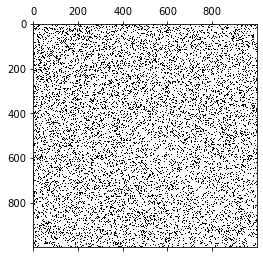

In [21]:
plt.matshow(K, cmap = plt.cm.binary)

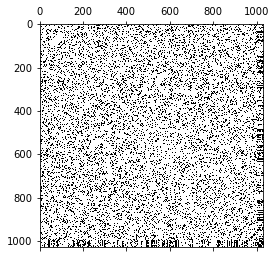

In [22]:
plt.matshow(A_combined, cmap = plt.cm.binary)

# 2. Algorithm

In [23]:
Z = 0
Lambda = 0
rho = 1
max_iter = 100
alpha = 0
lam = .11

In [24]:
D = np.zeros((N, N))
np.fill_diagonal(D, np.diag(A_combined @ np.full((N, N), 1)) / N)

In [25]:
E = - (np.eye(N) - D) ** (1 / 2) @ A_combined @ (np.eye(N) - D) ** (1 / 2) +  D ** (1 / 2) @ (np.full((N, N), 1) - np.eye(N) - A_combined) @ D ** (1 / 2)

In [26]:
k = 0
time.start = time.time()
while k < max_iter:
    if k % 10 == 0:
        print("k = ", k, time.time() - time.start, "\n")
    # 1. Update Y ========
    
    X = Z - Lambda - E / rho
    X_values, V = eig(X)

    X_values_plus = X_values * (X_values > 0)
    Sigma_plus = np.zeros((N, N))
    np.fill_diagonal(Sigma_plus, X_values_plus)

    X_plus = V @ Sigma_plus @ V.transpose()
    Y = X_plus
    
    # 2. Update Z ========
    inside = (Y + Lambda) * (Y + Lambda > 0)
    Z = inside * (inside > 1) +  np.full((N, N), 1) * (inside <= 1)
    
    # 3. Update Lambda ========
    Lambda = Lambda + (Y - Z)
    
    k += 1

k =  0 0.0001308917999267578 

k =  10 37.81009101867676 

k =  20 76.86437892913818 

k =  30 117.54309678077698 

k =  40 159.2011640071869 

k =  50 200.51796293258667 

k =  60 240.02783274650574 

k =  70 283.0871489048004 

k =  80 325.89458894729614 

k =  90 368.50104999542236 



In [27]:
Xhat = Y
Xhat_normalized = normalize(Xhat, axis = 1, norm = 'l2')


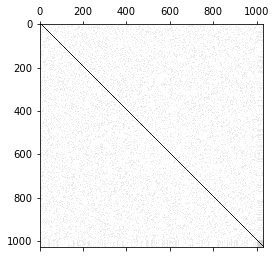

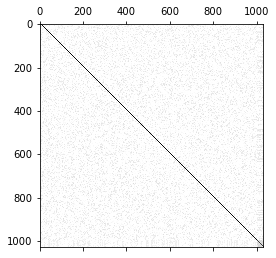

In [28]:
plt.matshow(Xhat, cmap = plt.cm.binary)
plt.matshow(Xhat_normalized, cmap = plt.cm.binary)

In [29]:
yhat_list = []
mis_rates = []

mis_rates_inlier = []
for seed in range(100):
    kmeans = KMeans(n_clusters = 2, random_state = seed).fit(Xhat)
    yhat = kmeans.labels_
    yhat_list = yhat_list + [yhat]
    
    mis_rate = cal_mis_rate(phi_o, yhat)
    mis_rates = mis_rates + [mis_rate]
    
    mis_rate_inlier = cal_mis_rate(phi_o[:n], yhat[:n])
    mis_rates_inlier = mis_rates_inlier + [mis_rate_inlier]
    
    print("seed = ", seed, "mis rate inlier = ", mis_rate_inlier,
          ", mis rate = ", mis_rate, "\n")

seed =  0 mis rate inlier =  0.487 , mis rate =  0.4689320388349515 

seed =  1 mis rate inlier =  0.5 , mis rate =  0.4854368932038835 

seed =  2 mis rate inlier =  0.493 , mis rate =  0.47864077669902916 

seed =  3 mis rate inlier =  0.495 , mis rate =  0.48058252427184467 

seed =  4 mis rate inlier =  0.5 , mis rate =  0.4563106796116505 

seed =  5 mis rate inlier =  0.486 , mis rate =  0.4718446601941747 

seed =  6 mis rate inlier =  0.493 , mis rate =  0.46310679611650485 

seed =  7 mis rate inlier =  0.491 , mis rate =  0.46504854368932036 

seed =  8 mis rate inlier =  0.486 , mis rate =  0.4699029126213592 

seed =  9 mis rate inlier =  0.494 , mis rate =  0.46213592233009704 

seed =  10 mis rate inlier =  0.496 , mis rate =  0.4815533980582525 

seed =  11 mis rate inlier =  0.492 , mis rate =  0.46407766990291266 

seed =  12 mis rate inlier =  0.496 , mis rate =  0.4815533980582525 

seed =  13 mis rate inlier =  0.5 , mis rate =  0.4854368932038835 

seed =  14 mis r

In [30]:
print("Averaged misclassification rate of inliers is ", np.mean(mis_rates_inlier), ", \n",
     "Averaged misclassification rate for all nodes is ", np.mean(mis_rates))

Averaged misclassification rate of inliers is  0.49376000000000003 , 
 Averaged misclassification rate for all nodes is  0.46891262135922335
